## Import libraries and dependencies

In [ ]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
from statistics import median

# tensorflow libraries
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback

# sklearn libraries
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
drive.mount('/drive')

Mounted at /drive


In [ ]:
import os
os.chdir("/drive/My Drive/ntu academia/cs y3/cz4042 NN/assignment")

## Read and process data

In [ ]:
df = pd.read_csv('features_30_sec.csv')
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,harmony_var,perceptr_mean,perceptr_var,tempo,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,3805.839606,9.015054e+05,0.083045,0.000767,-4.529724e-05,0.008172,0.000008,0.005698,123.046875,-113.570648,2564.207520,121.571793,295.913818,-19.168142,235.574432,42.366421,151.106873,-6.364664,167.934799,18.623499,89.180840,-13.704891,67.660492,15.343150,68.932579,-12.274110,82.204201,10.976572,63.386311,-8.326573,61.773094,8.803792,51.244125,-3.672300,41.217415,5.747995,40.554478,-5.162882,49.775421,0.752740,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,3550.522098,2.977893e+06,0.056040,0.001448,1.395807e-04,0.005099,-0.000178,0.003063,67.999589,-207.501694,7764.555176,123.991264,560.259949,8.955127,572.810913,35.877647,264.506104,2.907320,279.932922,21.510466,156.477097,-8.560436,200.849182,23.370686,142.555954,-10.099661,166.108521,11.900497,104.358612,-5.555639,105.173630,5.376327,96.197212,-2.231760,64.914291,4.220140,73.152534,-6.012148,52.422142,0.927998,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,3042.260232,7.840345e+05,0.076291,0.001007,2.105576e-06,0.016342,-0.000019,0.007458,161.499023,-90.722595,3319.044922,140.446304,508.765045,-29.093889,411.781219,31.684334,144.090317,-13.984504,155.493759,25.764742,74.548401,-13.664875,106.981827,11.639934,106.574875,-11.783643,65.447945,9.718760,67.908859,-13.133803,57.781425,5.791199,64.480209,-8.907628,60.385151,-1.077000,57.711136,-9.229274,36.580986,2.451690,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,2184.745799,1.493194e+06,0.033309,0.000423,4.583644e-07,0.019054,-0.000014,0.002712,63.024009,-199.544205,5507.517090,150.090897,456.505402,5.662678,257.161163,26.859079,158.267303,1.771399,268.034393,14.234031,126.794128,-4.832006,155.912079,9.286494,81.273743,-0.759186,92.114090,8.137607,71.314079,-3.200653,110.236687,6.079319,48.251999,-2.480174,56.799400,-1.079305,62.289902,-2.870789,51.651592,0.780874,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,3579.757627,1.572978e+06,0.101461,0.001954,-1.756129e-05,0.004814,-0.000010,0.003094,135.999178,-160.337708,5195.291992,126.219635,853.784729,-35.587811,333.792938,22.148071,193.456100,-32.478600,336.276825,10.852294,134.831573,-23.352329,93.257095,0.498434,124.672127,-11.793437,130.073349,1.207256,99.675575,-13.088418,80.254066,-2.813867,86.430626,-6.933385,89.555443,-7.552725,70.943336,-9.164666,75.793404,-4.520576,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [ ]:
columns_to_drop = ['label','filename', 'length']

# utility function to prepare inputs and outputs from dataset
def prepare_dataset(df, columns_to_drop, test_size, random_state):
    """
    Returns scaled x train and test dataframes and y train and test dataframes.
    
    Parameters:
        df (DataFrame): DataFrame containing dataset of input features and target labels
        columns_to_drop (list): List of string column labels not required for task
        test_size (float or int): Decimal float to indicate train test split
        random_state (int): Integer to control shuffling applied to the data before split

    Returns:
        x_train_scaled (ndarray): NumPy array of scaled training input data
        y_train (ndarray): NumPy array of training output data
        x_test_scaled (ndarray): NumPy array of scaled test input data
        y_test (ndarray): NumPy array of test output data
    """

    # encode the labels from 0 to n_classes-1  
    label_encoder = preprocessing.LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])
  
    # divide data to train and test
    df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
    
    # scale and prepare training inputs
    x_train = df_train.drop(columns_to_drop,axis=1)
    y_train = df_train['label'].to_numpy()
    standard_scaler = preprocessing.StandardScaler()
    x_train_scaled = standard_scaler.fit_transform(x_train)

    # scale and prepare testing data
    x_test = df_test.drop(columns_to_drop,axis=1)
    x_test_scaled = standard_scaler.transform(x_test)
    y_test = df_test['label'].to_numpy() 
  
    return x_train_scaled, y_train, x_test_scaled, y_test

In [ ]:
# prepare inputs and outputs from dataset
X_train, y_train, X_test, y_test = prepare_dataset(df, columns_to_drop, test_size=0.3, random_state=0)

# QUESTION 1


**1a) Use the training dataset to train the model for 50 epochs.**

### Build Deep Neural Network

In [ ]:
# set parameters
batch_size = 1
no_epochs = 50

# build DNN
network = Sequential([
      Dense(16, activation="relu"),
      Dropout(0.3),
      Dense(10, activation="softmax")
      ])

# set 'adam' optimizer and loss function
network.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

### Stochastic Gradient Descent

In [ ]:
# fit network on training data
history = network.fit(X_train, y_train,
                      epochs=no_epochs,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/50
700/700 [==============================] - 2s 2ms/step - loss: 2.1667 - accuracy: 0.2557 - val_loss: 1.7874 - val_accuracy: 0.3767
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.6612 - accuracy: 0.3914 - val_loss: 1.5219 - val_accuracy: 0.4733
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.4745 - accuracy: 0.4700 - val_loss: 1.3702 - val_accuracy: 0.5367
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3687 - accuracy: 0.5043 - val_loss: 1.2717 - val_accuracy: 0.5633
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 1.2602 - accuracy: 0.5371 - val_loss: 1.2141 - val_accuracy: 0.6133
Epoch 6/50
700/700 [==============================] - 1s 1ms/step - loss: 1.1815 - accuracy: 0.5771 - val_loss: 1.1786 - val_accuracy: 0.5867
Epoch 7/50
700/700 [==============================] - 1s 1ms/step - loss: 1.1690 - accuracy: 0.5757 - val_loss: 1.1146 - val_accuracy: 0.6200
Epoch 

**1b) Plot accuracies on training and test data against training epochs and comment on the plots.**

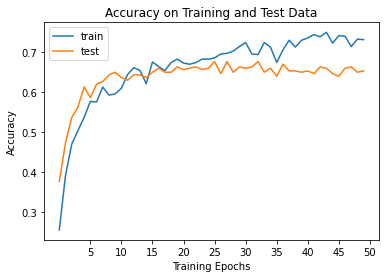

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy on Training and Test Data')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')

It is evident from the plot that both training and test accuracy are somewhat similar, with both continuing to increase with more training epochs.

**1c) Plot the losses on training and test data against training epochs. State the
approximate number of epochs where the test error begins to converge.**

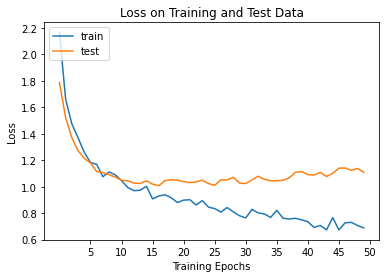

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss on Training and Test Data')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')

From the plot, test error begins to converge at approximately 7 epochs.

# QUESTION 2

**2a) Plot mean cross-validation accuracies  over the training epochs for different batch sizes. Limit search space to batch sizes {1,4,8,16,32, 64}.**

In [ ]:
# set parameters and seed
no_epochs = 50
no_labels = 10
no_folds = 3
seed = 10
no_data = 1000
tf.random.set_seed(seed)
np.random.seed(seed)

### Define callbacks for storing batch and epoch times

In [ ]:
class time_for_batch(Callback):

"""Records time taken for training each batch of data."""

  def on_train_begin(self, logs={}):
    """Called at the beginning of training."""
    self.times_batch = []

  def on_train_batch_begin(self, batch, logs={}):
    """Called at the beginning of processing a batch during training."""
    self.starttime = time.time()

  def on_train_batch_end(self, batch, logs={}):
    """Called at the end of processing a batch during training."""
    self.times_batch.append(time.time() - self.starttime)

In [ ]:
class time_for_epoch(Callback): 

"""Records time taken for training each epoch of data."""

  def on_train_begin(self, logs={}):
    """Called at the beginning of training."""
    self.times_epoch = []

  def on_epoch_begin(self, epoch, logs={}):
    """Called at the beginning of processing an epoch during training."""
    self.epoch_time_start = time.time()

  def on_epoch_end(self, epoch, logs={}):
    """Called at the end of processing a batch during training."""
    self.times_epoch.append(time.time() - self.epoch_time_start)

### Process and prepare data

In [ ]:
columns_to_drop = ['label','filename', 'length']

# encode the labels from 0 to n_classes-1  
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
      
# prepare input features X and labels Y
# Y is an ndarray of dimension (1000,1)
X = df.drop(columns_to_drop,axis=1)   
Y = df['label'].to_numpy()  

# scale and prepare input features
# x_scaled is nd_array of dimension (1000, 57)
standard_scaler = preprocessing.StandardScaler()
x_scaled = standard_scaler.fit_transform(X)

### 3-Fold cross-validation to determine optimal batch size

In [ ]:
kf = KFold(n_splits=no_folds, 
           random_state=None, 
           shuffle=True)

In [ ]:
# initialize search space and dictionaries to store metrics
batch_sizes = [1, 4, 8, 16, 32, 64]
cv_accuracy = {}
train_accuracy = {}
epoch_training_time = {}
batch_training_time = {}

# for each batch size in search space
for mini_batch_size in batch_sizes:
  fold = 1
  # for each of 3 folds 
  for train_index, test_index in kf.split(x_scaled, Y):
    X_train = x_scaled[train_index, :]
    X_test = x_scaled[test_index, :]
    y_train = Y[train_index]
    y_test = Y[test_index]

    model = Sequential([
      Dense(16, activation="relu"),
      Dropout(0.3),
      Dense(10, activation="softmax")
      ])
  
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    
    tb = time_for_batch()
    te = time_for_epoch()

    history = model.fit(X_train, y_train,
                        epochs=no_epochs,
                        batch_size=mini_batch_size,
                        verbose=2,
                        use_multiprocessing=False,
                        callbacks=[tb, te],
                        validation_data=(X_test, y_test))
    
    cv_accuracy[(mini_batch_size, fold)] = history.history['val_accuracy']
    train_accuracy[(mini_batch_size, fold)] = history.history['accuracy']
    epoch_training_time[(mini_batch_size, fold)] = te.times_epoch
    batch_training_time[(mini_batch_size, fold)] = tb.times_batch

    fold += 1

Epoch 1/50
666/666 - 2s - loss: 2.2518 - accuracy: 0.2177 - val_loss: 1.7868 - val_accuracy: 0.3802
Epoch 2/50
666/666 - 1s - loss: 1.8178 - accuracy: 0.3168 - val_loss: 1.5605 - val_accuracy: 0.4401
Epoch 3/50
666/666 - 1s - loss: 1.5635 - accuracy: 0.4024 - val_loss: 1.3893 - val_accuracy: 0.5449
Epoch 4/50
666/666 - 1s - loss: 1.5043 - accuracy: 0.4535 - val_loss: 1.2842 - val_accuracy: 0.5509
Epoch 5/50
666/666 - 1s - loss: 1.3599 - accuracy: 0.5090 - val_loss: 1.1901 - val_accuracy: 0.5629
Epoch 6/50
666/666 - 1s - loss: 1.3440 - accuracy: 0.5090 - val_loss: 1.1554 - val_accuracy: 0.5958
Epoch 7/50
666/666 - 1s - loss: 1.2598 - accuracy: 0.5405 - val_loss: 1.1053 - val_accuracy: 0.6078
Epoch 8/50
666/666 - 1s - loss: 1.2256 - accuracy: 0.5270 - val_loss: 1.0715 - val_accuracy: 0.6168
Epoch 9/50
666/666 - 1s - loss: 1.1909 - accuracy: 0.5616 - val_loss: 1.0365 - val_accuracy: 0.6617
Epoch 10/50
666/666 - 1s - loss: 1.1587 - accuracy: 0.5781 - val_loss: 1.0160 - val_accuracy: 0.6707

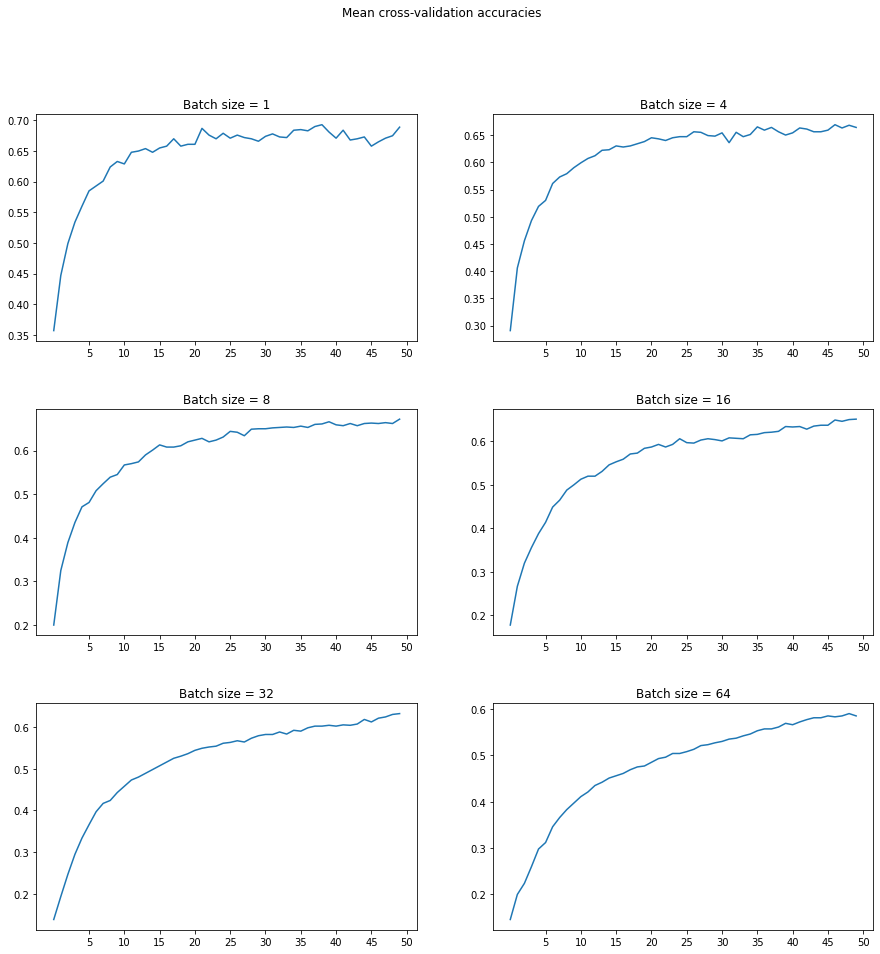

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(15,15))
fig.suptitle("Mean cross-validation accuracies")

acc = {}
for i in batch_sizes:
  a = np.array(cv_accuracy[(i,1)])
  b = np.array(cv_accuracy[(i,2)])
  c = np.array(cv_accuracy[(i,3)])
  acc[i] = np.mean([a,b,c], axis=0)

axs[0,0].plot(acc[1])
axs[0,1].plot(acc[4])
axs[1,0].plot(acc[8])
axs[1,1].plot(acc[16])
axs[2,0].plot(acc[32])
axs[2,1].plot(acc[64])

axs[0,0].set_title('Batch size = 1')
axs[0,1].set_title('Batch size = 4')
axs[1,0].set_title('Batch size = 8')
axs[1,1].set_title('Batch size = 16')
axs[2,0].set_title('Batch size = 32')
axs[2,1].set_title('Batch size = 64')


plt.setp(axs, xticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.subplots_adjust(hspace=0.3)
plt.show()

**2b) Create a table of median time taken to train the network for one epoch against different batch sizes.**

In [ ]:
# create dictionary to store median epoch times
median_epoch_times = {}

# for each batch size, compute median time for 1 training epoch
for i in batch_sizes:
  a = np.array(epoch_training_time[(i,1)])
  b = np.array(epoch_training_time[(i,2)])
  c = np.array(epoch_training_time[(i,3)])
  mean_epoch_time = np.mean([a,b,c], axis=0)
  median_epoch_times[i] = np.median(mean_epoch_time)

In [ ]:
# print column headers in table
print ("{:<10} {:<10}".format('Batch Size', 'Median time taken per training epoch/s'))
 
# print batch sizes and median times
for key, value in median_epoch_times.items():
    print ("{:<10} {:<10}".format(key, round(value, 4)))

Batch Size Median time taken per training epoch/s
1          1.0632    
4          0.3299    
8          0.1772    
16         0.0992    
32         0.0668    
64         0.0515    


**2c) Select the optimal batch size and state reasons for your selection.**

Based on the cross-validation accuracy graphs, we can eliminate batch sizes of 32 and 64 as the maximum test accuracy reached within 50 epochs is significantly lower than 0.65. This is probably due to the model generalizing more as batch size increases. We can also eliminate a batch size of 1, as we can see that test accuracy does not actually converge, instead fluctuating in the 0.65-0.7 range.

Between the remaining batch sizes, batch sizes 4 and 8 yield a higher cross-validation accuracy than batch size 16, reaching almost 0.7. However, between the 2, I would select batch size 8 as it has more than a 0.1s shorter epoch training time than batch size 4. With 50 epochs to train, this could lower the time taken to fit the model by more than 5 seconds, which can be valuable when deploying the model in a practical context.

**2d) What is the difference between mini-batch gradient descent and stochastic gradient descent and what does this mean for model training?**

The main difference between mini-batch GD and SGD is that mini-batch GD computes the gradient descent based on an entire batch of training samples for a specific batch size, whereas SGD does so using a single randomly selected training sample. 

From the efficiency perspective, this means that mini-batch GD is computationally expensive as it requires much more time and memory to carry out calculations over all samples in a batch during each epoch. Hence the model requires more training time if it is using mini-batch GD. 

In terms of validation accuracy, SGD is likely to give a noisier path to the minima, and cost is likely to fluctuate heavily. Due to its stochastic rather than deterministic nature, training a model with SGD may not give optimal results, but could result in faster convergence, especially with larger datasetes.

**2e) Plot the train and test accuracies against epochs for the optimal batch size.**

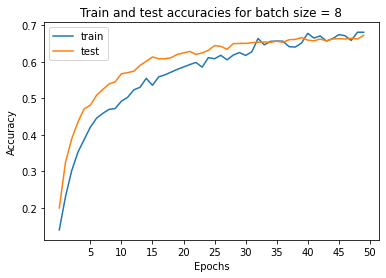

In [ ]:
opt_batch_size = 8

# create array to store training accuracy over epochs
a = np.array(train_accuracy[(opt_batch_size,1)])
b = np.array(train_accuracy[(opt_batch_size,2)])
c = np.array(train_accuracy[(opt_batch_size,3)])
train_acc = np.mean([a,b,c], axis=0)

# plot train and test accuracies for optimal batch size
plt.figure()
plt.plot(train_acc)
plt.plot(acc[opt_batch_size])
plt.title('Train and test accuracies for batch size = 8')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# QUESTION 3

**3a) Plot the cross-validation accuracies against training epochs for different
numbers of hidden-layer neurons. Limit the search space of the number of
neurons to {8, 16, 32, 64}. Continue using 3-fold cross validation on training dataset.**

In [ ]:
# set parameters
no_epochs = 50
no_labels = 10
no_folds = 3
opt_batch_size = 8

In [ ]:
kf = KFold(n_splits=no_folds, 
           random_state=None, 
           shuffle=True)

In [ ]:
# initialize search space and dictionaries to store metrics
hidden_neurons = [8, 16, 32, 64]
cv_accuracy = {}
train_accuracy = {}

# for each number of neurons in search space
for no_neurons in hidden_neurons:
  fold = 1
  # for each of 3 folds 
  for train_index, test_index in kf.split(x_scaled, Y):
    X_train = x_scaled[train_index, :]
    X_test = x_scaled[test_index, :]
    y_train = Y[train_index]
    y_test = Y[test_index]

    model = Sequential([
      Dense(no_neurons, activation="relu"),
      Dropout(0.3),
      Dense(10, activation="softmax")
      ])
  
    model.compile(optimizer="adam", 
                  loss="sparse_categorical_crossentropy",
                  metrics=['accuracy'])
    
    tb = time_for_batch()
    te = time_for_epoch()

    history = model.fit(X_train, y_train,
                        epochs=no_epochs,
                        batch_size=opt_batch_size,
                        verbose=2,
                        use_multiprocessing=False,
                        callbacks=[tb, te],
                        validation_data=(X_test, y_test))
    
    cv_accuracy[(no_neurons, fold)] = history.history['val_accuracy']
    train_accuracy[(no_neurons, fold)] = history.history['accuracy']
    epoch_training_time[(mini_batch_size, fold)] = te.times_epoch
    batch_training_time[(mini_batch_size, fold)] = tb.times_batch

    fold += 1

Epoch 1/50
84/84 - 1s - loss: 2.6774 - accuracy: 0.0931 - val_loss: 2.3553 - val_accuracy: 0.1766
Epoch 2/50
84/84 - 0s - loss: 2.2797 - accuracy: 0.1982 - val_loss: 2.1006 - val_accuracy: 0.2545
Epoch 3/50
84/84 - 0s - loss: 2.0955 - accuracy: 0.2538 - val_loss: 1.9711 - val_accuracy: 0.3114
Epoch 4/50
84/84 - 0s - loss: 2.0076 - accuracy: 0.2432 - val_loss: 1.8764 - val_accuracy: 0.3743
Epoch 5/50
84/84 - 0s - loss: 1.9091 - accuracy: 0.3078 - val_loss: 1.8168 - val_accuracy: 0.3892
Epoch 6/50
84/84 - 0s - loss: 1.8802 - accuracy: 0.3288 - val_loss: 1.7578 - val_accuracy: 0.4102
Epoch 7/50
84/84 - 0s - loss: 1.8174 - accuracy: 0.3453 - val_loss: 1.7070 - val_accuracy: 0.4371
Epoch 8/50
84/84 - 0s - loss: 1.7900 - accuracy: 0.3393 - val_loss: 1.6707 - val_accuracy: 0.4760
Epoch 9/50
84/84 - 0s - loss: 1.7678 - accuracy: 0.3619 - val_loss: 1.6354 - val_accuracy: 0.5030
Epoch 10/50
84/84 - 0s - loss: 1.7326 - accuracy: 0.3754 - val_loss: 1.6068 - val_accuracy: 0.4910
Epoch 11/50
84/84 -

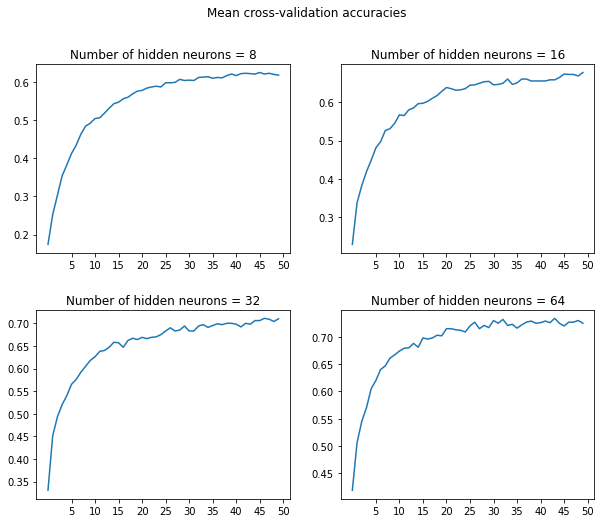

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
fig.suptitle("Mean cross-validation accuracies")

acc = {}
for i in hidden_neurons:
  a = np.array(cv_accuracy[(i,1)])
  b = np.array(cv_accuracy[(i,2)])
  c = np.array(cv_accuracy[(i,3)])
  acc[i] = np.mean([a,b,c], axis=0)

axs[0,0].plot(acc[8])
axs[0,1].plot(acc[16])
axs[1,0].plot(acc[32])
axs[1,1].plot(acc[64])

axs[0,0].set_title('Number of hidden neurons = 8')
axs[0,1].set_title('Number of hidden neurons = 16')
axs[1,0].set_title('Number of hidden neurons = 32')
axs[1,1].set_title('Number of hidden neurons = 64')

plt.setp(axs, xticks=[5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.subplots_adjust(hspace=0.3)
plt.show()

**3b) Select the optimal number of neurons for the hidden layer. State the rationale for your selection.**

In terms of cross-validation accuracy, the model with 64 hidden layer neurons appears to converge to about 0.72, which the highest among the four models trained. Hence we can select 64 as the optimal number of neurons for the hidden layer.

**3c) Plot the train and test accuracies against training epochs with the optimal number of neurons.**

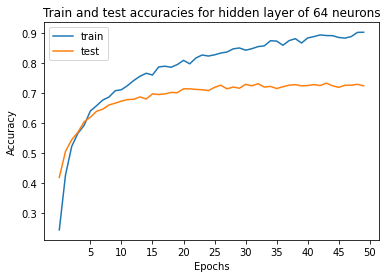

In [ ]:
opt_no_neurons = 64

# create array to store training accuracy over epochs
a = np.array(train_accuracy[(opt_no_neurons,1)])
b = np.array(train_accuracy[(opt_no_neurons,2)])
c = np.array(train_accuracy[(opt_no_neurons,3)])
train_acc = np.mean([a,b,c], axis=0)

# plot train and test accuracies for optimal number of hidden neurons
plt.figure()
plt.plot(train_acc)
plt.plot(acc[opt_no_neurons])
plt.title('Train and test accuracies for hidden layer of 64 neurons')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**3d) What other parameters could possibly be tuned?**

Parameters other than batch size and number of hidden layer neurons that can be tuned, include the optimizer, learning rate, number of epochs, number of folds in cross-validation and number of hidden layers.

# QUESTION 4

**4a) Plot the train and test accuracy of the 3-layer network against training epochs.**

In [ ]:
# set parameters
no_epochs = 50
no_labels = 10
no_folds = 3
opt_no_neurons = 64

In [ ]:
kf = KFold(n_splits=no_folds, 
           random_state=None, 
           shuffle=True)

In [ ]:
# create dictionaries to store metrics
cv_accuracy = {}
train_accuracy = {}

fold = 1
# for each of 3 folds
for train_index, test_index in kf.split(x_scaled, Y):
  X_train = x_scaled[train_index, :]
  X_test = x_scaled[test_index, :]
  y_train = Y[train_index]
  y_test = Y[test_index]

  model = Sequential([
    Dense(opt_no_neurons, activation="relu"),
    Dropout(0.3),
    Dense(opt_no_neurons, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="softmax")
    ])

  model.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  tb = time_for_batch()
  te = time_for_epoch()

  history = model.fit(X_train, y_train,
                      epochs=no_epochs,
                      batch_size=1,
                      verbose=2,
                      use_multiprocessing=False,
                      callbacks=[tb, te],
                      validation_data=(X_test, y_test))
  
  cv_accuracy[fold] = history.history['val_accuracy']
  train_accuracy[fold] = history.history['accuracy']
  epoch_training_time[(mini_batch_size, fold)] = te.times_epoch
  batch_training_time[(mini_batch_size, fold)] = tb.times_batch

  fold += 1

Epoch 1/50
666/666 - 2s - loss: 1.9513 - accuracy: 0.2883 - val_loss: 1.4876 - val_accuracy: 0.4790
Epoch 2/50
666/666 - 1s - loss: 1.4853 - accuracy: 0.4505 - val_loss: 1.2366 - val_accuracy: 0.5749
Epoch 3/50
666/666 - 1s - loss: 1.2893 - accuracy: 0.5285 - val_loss: 1.0989 - val_accuracy: 0.6347
Epoch 4/50
666/666 - 1s - loss: 1.1610 - accuracy: 0.5706 - val_loss: 1.0227 - val_accuracy: 0.6647
Epoch 5/50
666/666 - 1s - loss: 1.0690 - accuracy: 0.5901 - val_loss: 0.9680 - val_accuracy: 0.6796
Epoch 6/50
666/666 - 1s - loss: 0.9528 - accuracy: 0.6517 - val_loss: 1.0110 - val_accuracy: 0.6677
Epoch 7/50
666/666 - 1s - loss: 0.8482 - accuracy: 0.6982 - val_loss: 0.9819 - val_accuracy: 0.6916
Epoch 8/50
666/666 - 1s - loss: 0.8319 - accuracy: 0.7297 - val_loss: 0.9435 - val_accuracy: 0.6916
Epoch 9/50
666/666 - 1s - loss: 0.7930 - accuracy: 0.7057 - val_loss: 0.9277 - val_accuracy: 0.7006
Epoch 10/50
666/666 - 1s - loss: 0.7024 - accuracy: 0.7462 - val_loss: 0.9181 - val_accuracy: 0.7126

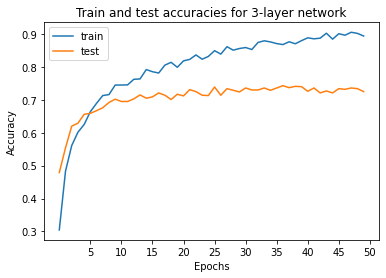

In [ ]:
# create array to store training accuracy over epochs
train_acc = np.mean([np.array(train_accuracy[1]),
                     np.array(train_accuracy[2]),
                     np.array(train_accuracy[3])], axis=0)

# create array to store validation accuracy over epochs
cv_acc = np.mean([np.array(cv_accuracy[1]),
                  np.array(cv_accuracy[2]),
                  np.array(cv_accuracy[3])], axis=0)

# plot train and test accuracies for 3-layer network
plt.figure()
plt.plot(train_acc)
plt.plot(cv_acc)
plt.title('Train and test accuracies for 3-layer network')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**4b) Compare and comment on the performances of the optimal 2-layer network from your hyperparameter tuning in Question 2 and 3 and the 3-layer network.**

Based on only cross-validation accuracy, the difference between the accuracies for the optimal 2-layer network and the 3-layer network is rather negligible. In fact, the 3-layer network takes a longer time to train 50 epochs compared to the 2-layer network, while keeping all other parameters constant. Therefore, it can be said that increasing the number of hidden layers in the neural network does not yield better performance, and actually compromises on efficiency.

# QUESTION 5

**5a) Why do we add dropouts? Investigate the purpose of dropouts by removing
dropouts from your original 2-layer network (before changing the batch size
and number of neurons). Plot accuracies on training and test data with neural
network without dropout. Plot as well the losses on training and test data with
neural network without dropout.**

In [ ]:
# set parameters
batch_size = 1
no_epochs = 50

# build DNN without dropouts
network = Sequential([
      Dense(16, activation="relu"),
      Dense(10, activation="softmax")
      ])

# set 'adam' optimizer and loss function
network.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])

In [ ]:
# fit network without dropouts on training data
history = network.fit(X_train, y_train,
                      epochs=no_epochs,
                      batch_size=batch_size,
                      validation_data=(X_test, y_test))

Epoch 1/50
700/700 [==============================] - 2s 2ms/step - loss: 1.8472 - accuracy: 0.3343 - val_loss: 1.5347 - val_accuracy: 0.4800
Epoch 2/50
700/700 [==============================] - 1s 2ms/step - loss: 1.3076 - accuracy: 0.5429 - val_loss: 1.3617 - val_accuracy: 0.5067
Epoch 3/50
700/700 [==============================] - 1s 2ms/step - loss: 1.1138 - accuracy: 0.6000 - val_loss: 1.2876 - val_accuracy: 0.5233
Epoch 4/50
700/700 [==============================] - 1s 2ms/step - loss: 1.0076 - accuracy: 0.6386 - val_loss: 1.2212 - val_accuracy: 0.5667
Epoch 5/50
700/700 [==============================] - 1s 2ms/step - loss: 0.9231 - accuracy: 0.6900 - val_loss: 1.1651 - val_accuracy: 0.6133
Epoch 6/50
700/700 [==============================] - 1s 2ms/step - loss: 0.8499 - accuracy: 0.7100 - val_loss: 1.1517 - val_accuracy: 0.6033
Epoch 7/50
700/700 [==============================] - 1s 2ms/step - loss: 0.7838 - accuracy: 0.7400 - val_loss: 1.1379 - val_accuracy: 0.6100
Epoch 

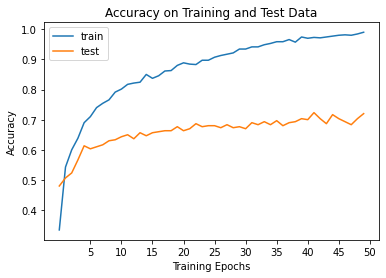

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy on Training and Test Data')
plt.ylabel('Accuracy')
plt.xlabel('Training Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')

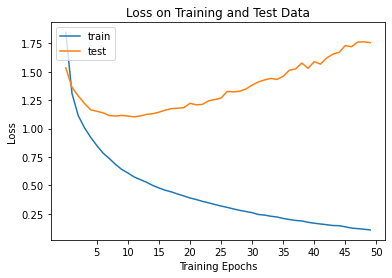

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss on Training and Test Data')
plt.ylabel('Loss')
plt.xlabel('Training Epochs')
plt.xticks([5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
plt.legend(['train', 'test'], loc='upper left')

**5b) Explain the effect of removing dropouts.**

When dropouts are removed, we notice that training accuracy approaches 1 significantly faster than with dropouts. Furthermore, while training loss decreases smoothly to about 0.1 by the end of 50 epochs, test loss decreases and begins increase after about 10 epochs, continuing to increase thereafter. This could indicate that removing dropouts from the model resulted in a greater degree of overfitting, meaning the resulting model performed extremely well on training data but poorly on test data.

**5c) What is another approach that you could take to address overfitting in the model?**

L1 and L2 Regularization can be used to minimize the absolute value of the weights and the squared magnitude of the weights respectively. 

# CONCLUSION

In Part A, we firstly established a comparison between stochastic gradient descent (SGD) and mini-batch gradient descent. From the results, it was decided that the optimal batch size was 8, due to considerations of shorter epoch training time as well as higher cross-validation accuracy. It was found empirically that the greater the batch size, the faster the epoch training time; however, beyond the optimal batch size of 8, a decrease in cross-validation accuracy was being observed.

We also found that the optimal number of hidden layer neurons was 64, based on the superior cross-validation accuracy it resulted in. 

Lastly, it was established that increasing the number of layers in the neural network built does not greatly affect test accuracy. It only gives a noisier path to convergence. Furthermore, it was crucial to include a dropout layer in the neural network to ensure the extent of overfitting was minimized.

Practically speaking, limitations of the current approach taken are plenty. Firstly, the dataset used in this problem to train deep neural networks contains a single label for each audio file, leading to our model classifying audio files into single genres. However, certain music can technically be classified in more than one genre as musical genres are not mutually exclusive. Hence a single-label classification problem may not be entirely useful in a practical context. We can model this better by carrying out multilabel classification, using approaches such as One-vs-the-Rest, which divides the problem into several binary classification tasks for each possible label, or models such as Long Short-Term Memory (LSTM) Networks that are better equipped to handle multi-label classification tasks. 

The approach used in this project has made use of a dataset that converted the audio files into numerical values representing each input feature. This enabled us to use Feedforward Neural Networks (FNNs) to classify the audio files into genres. However, considering the fact that the audio tracks are originally waveforms, it is possible that models more commonly used for image classification, such as Convolutional Neural Networks (CNNs), could be employed for this task instead to give better performance. These networks could take in as input an image dataset of waveform spectograms.

This is supported by research by Huang et al. (2018) which proposed that an using images of frequency-based mel-spectograms (instead of extracting numerical features from raw audio data) yielded greater test accuracy on the GTZAN dataset. It was also established that CNNs performed better than K-Nearest Neighbours models and FNNs at this image classification task.

Alternatively, given that the spectograms are time series data, implementing a Recurrent Neural Network (RNN) such as LSTM could also possibly be better-suited to this music genre classification task as it is more likely to learn sequence and temporal dependence in the data.

In extension, this approach of training Deep Neural Networks, especially RNNs, on waveform data can be applied to other practical uses such as speech and language recognition. In these contexts, the RNN might even need to adopt an attention-based encoder-decoder structure in order to implicitly learn the alignment between input and output sequences, which could be even more crucial for speech and language recognition than for classifying music genres.

# REFERENCES

Huang, D. A., Serafini, A. A., &amp; Pugh, E. J. (2018). Music Genre Classification (thesis). Retrieved October 12, 2021, from https://www.semanticscholar.org/paper/Music-Genre-Classification-Huang/e227c6e31b849409fae6a7ff885f0a2451a3b203. 